In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [18]:
import os
from PIL import Image
import pandas as pd

image_dir = "/home/jay/Face_Analysis/datasets/age_prediction/crop_part1"


images = []
ages = []
genders = []

# Loop through images
for filename in os.listdir(image_dir)[:8000]:
    try:
        age, gender = map(int, filename.split("_")[:2])
        img_path = os.path.join(image_dir, filename)
        img = Image.open(img_path).convert("RGB")

        ages.append(age)
        genders.append(gender)
        images.append(img)

    except Exception as e:
        print(f"Skipping file {filename}: {e}")

# Create a DataFrame
df = pd.DataFrame({
    "Images": images,
    "Ages": ages,
    "Genders": genders
})

df.head()


,Images,Ages,Genders
0,<PIL.Image.Image image mode=RGB size=200x200 a...,85,1
1,<PIL.Image.Image image mode=RGB size=200x200 a...,4,1
2,<PIL.Image.Image image mode=RGB size=200x200 a...,2,1
3,<PIL.Image.Image image mode=RGB size=200x200 a...,4,1
4,<PIL.Image.Image image mode=RGB size=200x200 a...,4,1


In [19]:
df['Genders'].value_counts()

Genders
1    4461
0    3539
Name: count, dtype: int64

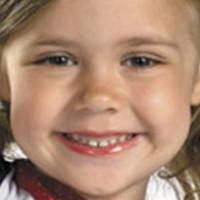

4 1


In [20]:
display(df['Images'][1])
print(df['Ages'][1],df['Genders'][1])

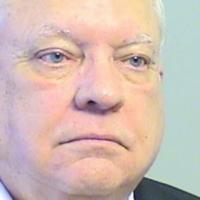

66 0


In [21]:
display(df['Images'][7000])
print(df['Ages'][7000], df['Genders'][7000])

<Axes: xlabel='Ages', ylabel='Count'>

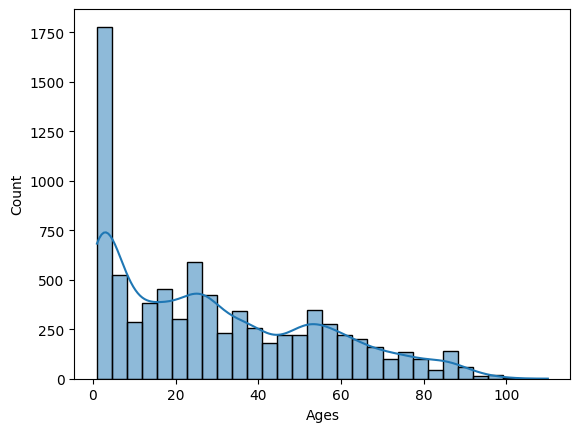

In [22]:
sns.histplot(df['Ages'],kde=True,bins=30)

In [23]:
under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac = 0.3)

df = df[df['Ages'] > 4]
df = pd.concat([df,under4s],ignore_index = True)

<Axes: xlabel='Ages', ylabel='Count'>

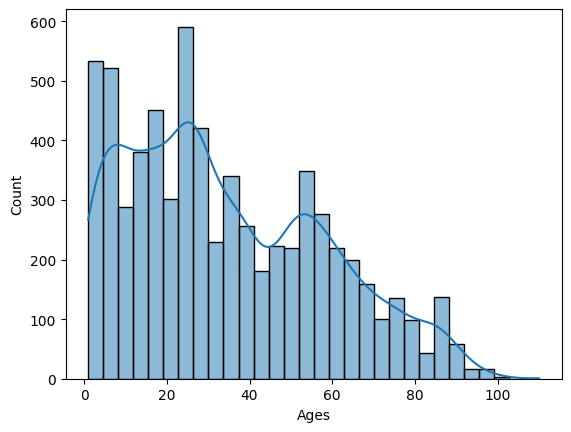

In [24]:
sns.histplot(df['Ages'],kde=True, bins=30)

In [25]:
df = df[df['Ages'] < 80]

<Axes: xlabel='Ages', ylabel='Count'>

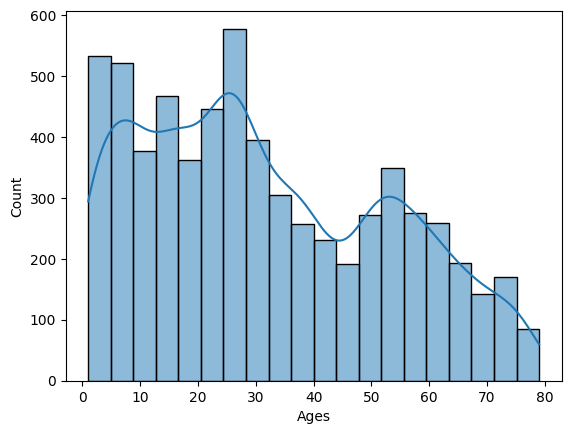

In [26]:
sns.histplot(df['Ages'],kde=True, bins=20)

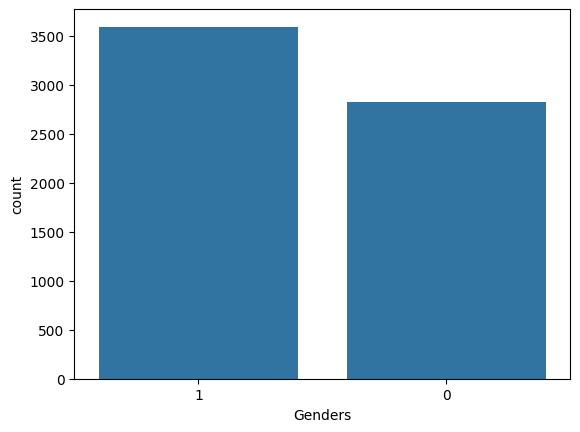

In [31]:
sns.countplot(data=df,x='Genders', order=df.Genders.value_counts().index)
plt.show()